# Preprocessing

## Imports

In [ ]:
import pandas as pd
import numpy as np
import json
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
# 初始化ClinicalBERT模型
import os
local_model_path = "/Users/zrb/Downloads/Technation-Healthsync-2025-main/local_model"

try:
    # 尝试使用本地模型
    print("正在加载本地ClinicalBERT模型...")
    tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")  # 使用预训练tokenizer
    model = AutoModel.from_pretrained(local_model_path)
    print("本地ClinicalBERT模型加载完成")
except Exception as e:
    print(f"本地模型加载失败: {e}")
    print("回退到在线模型...")
    tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
    model = AutoModel.from_pretrained("medicalai/ClinicalBERT")
    print("在线ClinicalBERT模型加载完成")


## Merge Tables

In [136]:
patients_df = pd.read_csv("Patients.csv")
patients_df = patients_df[['patient_uhid', 'Age', 'Gender', 'Blood Type', 'smoke_status', 'drinking_status']]
tests_df = pd.read_csv("Tests.csv")
measurements_lookup_df = pd.read_csv("MeasurementsLookup.csv")
diagnoses_df = pd.read_csv("Diagnoses.csv")

conditions_of_interest = [8, 1, 9]
diagnoses_df = diagnoses_df[diagnoses_df['condition_id'].isin(conditions_of_interest)]

test_df = tests_df.merge(
        measurements_lookup_df,
        on='measurement_id',
        how='left'
    ).drop(columns=['measurement_id'], errors='ignore')

# Pivot so each measurement_name is a column
pivoted_df = test_df.pivot_table(
        index='patient_uhid',
        columns='measurement_name',
        values='value',
        aggfunc='max'
    ).reset_index()

required_labs = [
      "HbA1c_level", "blood_glucose", "BMI", "BUN",
      "Cholesterol", "HDL", "LDL", "Cr"
  ]
missing_count = pivoted_df[required_labs].isna().sum(axis=1)
pivoted_df = pivoted_df[missing_count <= 1]
pivoted_df = pivoted_df[['patient_uhid'] + required_labs]


# If a patient can have multiple conditions, decide on a single label per patient
diag_agg_df = (
        diagnoses_df.groupby('patient_uhid', as_index=False)
        .agg({'condition_id': 'first'})  # or 'last', 'mode', etc.
    )

merged_patients_df = pd.merge(
        patients_df,
        diag_agg_df,
        on='patient_uhid',
        how='left'
    )
final_df = pd.merge(
        merged_patients_df,
        pivoted_df,
        on='patient_uhid',
        how='inner'
    ).dropna(subset=['condition_id'])

pivoted_df

measurement_name,patient_uhid,HbA1c_level,blood_glucose,BMI,BUN,Cholesterol,HDL,LDL,Cr
18,24,NaN,129.31,30.7,2.88,3.80,1.37,2.30,55.0
39,47,NaN,93.55,23.3,3.07,8.26,1.93,4.62,46.9
50,61,NaN,106.52,27.4,5.35,4.76,1.29,2.61,86.1
55,67,NaN,95.98,40.1,4.60,6.80,1.10,4.50,54.0
57,69,NaN,102.34,34.3,4.80,3.48,0.85,2.01,84.5
...,...,...,...,...,...,...,...,...,...
8294,9961,NaN,70.06,35.8,4.74,7.03,1.22,4.26,70.9
8298,9965,NaN,63.65,24.0,4.76,4.70,1.57,2.78,66.0
8307,9975,NaN,164.77,37.0,4.70,5.70,3.60,1.60,53.0
8318,9988,NaN,93.20,32.6,6.25,3.71,1.27,2.07,87.5


## Distribution Overview

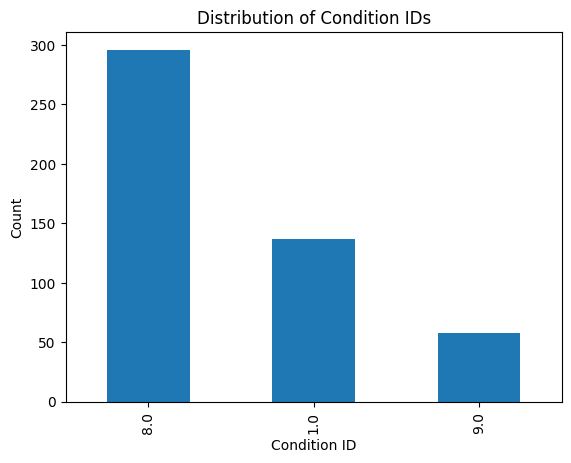

In [137]:
import matplotlib.pyplot as plt

# Using the original condition IDs:
distribution = final_df['condition_id'].value_counts()
distribution.plot(kind='bar')
plt.xlabel("Condition ID")
plt.ylabel("Count")
plt.title("Distribution of Condition IDs")
plt.show()

Checking NaNs

In [138]:
missing = final_df.isnull().sum()
print(final_df.isnull().sum())


patient_uhid         0
Age                  0
Gender               0
Blood Type           0
smoke_status         0
drinking_status      0
condition_id         0
HbA1c_level        491
blood_glucose        0
BMI                  0
BUN                  0
Cholesterol          0
HDL                  0
LDL                  0
Cr                   0
dtype: int64


Important Lab test factors:
+ HbA1c
+ Blood Glucose
+ BMI
+ BUN
+ Cholesterol
+ HDL
+ LDL
+ Cr
+ Trigycerides


Diagnoses to be considered:
+ Diabetes
+ Hypertension
+ Obesity
+ Cirrhosis
+ Heart Disease



Questions:
1. might need a separate model for liver-related diseases (different set of la tests)


## Feature Selection

In [139]:

from sklearn.impute import SimpleImputer
from pdb import set_trace as bp

# remove cols containing too much missing values
threshold = 0.95
n = final_df.shape[0]
cols_to_drop = []

for col in final_df.columns:
  missing_fraction = final_df[col].isna().mean()
  print(f"{col}: {missing_fraction}")
  if missing_fraction > threshold:
      cols_to_drop.append(col)

final_df = final_df.drop(columns=cols_to_drop)
print("Dropped columns:", cols_to_drop)





patient_uhid: 0.0
Age: 0.0
Gender: 0.0
Blood Type: 0.0
smoke_status: 0.0
drinking_status: 0.0
condition_id: 0.0
HbA1c_level: 1.0
blood_glucose: 0.0
BMI: 0.0
BUN: 0.0
Cholesterol: 0.0
HDL: 0.0
LDL: 0.0
Cr: 0.0
Dropped columns: ['HbA1c_level']


## Feature Encoding

In [140]:
final_df['condition_id'] = final_df['condition_id'].replace('Unknown', -1).astype(int)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df['condition_id_encoded'] = le.fit_transform(final_df['condition_id'])

# One-hot encode gender & blood type
cat_cols = ['Gender', 'Blood Type']
for col in cat_cols:
    if col in final_df.columns:
        final_df[col] = final_df[col].astype(str)

final_df = pd.get_dummies(
    final_df,
    columns=[c for c in cat_cols if c in final_df.columns],
    drop_first=True,
    dummy_na=False
)

drop_cols = ['patient_uhid', 'condition_id']

X = final_df.drop(columns=['condition_id_encoded'], errors='ignore')
y = final_df['condition_id_encoded']

class_counts = y.value_counts()
num_classes = len(class_counts)

print(class_counts)


condition_id_encoded
1    296
0    137
2     58
Name: count, dtype: int64


## Handling Class imbalance

In [147]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

counts = y.value_counts()
under_sampling_strategy = {1: 250}
over_sampling_strategy = {0: 250, 2: 100}
smote = SMOTE(sampling_strategy=over_sampling_strategy, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy=under_sampling_strategy)
X_smote, y_smote = smote.fit_resample(X, y)
X_resampled, y_resampled = rus.fit_resample(X_smote, y_smote)
print(y_resampled.value_counts())

condition_id_encoded
0    250
1    250
2    100
Name: count, dtype: int64


# Model Training

In [ ]:
! pip install --upgrade xgboost


In [148]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)
patients = X_test["patient_uhid"]
diagnoses = X_test["condition_id"]
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')
num_classes = len(np.unique(y))
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    objective='multi:softmax',
    num_class=num_classes,
    reg_alpha=0.1,      # L1
    reg_lambda=1.0,     # L2
    random_state=42,
    verbosity=1
)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

## Evaluation

In [154]:
lookup = pd.read_csv("ConditionsLookup.csv")
y_pred = model.predict(X_test)
y_prob =  model.predict_proba(X_test)
for patient, pred in zip(patients, y_prob): # Assuming X_test has an index representing patients
  s = ""
  for cond, prob in zip(le.classes_, pred):
    try:
        condition_name = lookup[lookup["condition_id"] == cond].drop(columns=["condition_id"])
        s += f"{condition_name}: {prob:.3f} | \n"
    except IndexError:
        s += f"Unknown Condition: {prob:.3f} | "
  print(f"Patient ID: {int(patient)}, Probability(risk) of diagnosis for the following conditions: \n {s}")

print("Classification Report:")
print(f"Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

print("\nCondition ID -> Encoded Class:")
for cond_id, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{cond_id} => {enc}")

model_filename = "xgb_model.pkl"
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")
print("Classification Report:")
print(f"Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

print("\nCondition ID -> Encoded Class:")
for cond_id, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{cond_id} => {enc}")

model_filename = "xgb_model.pkl"
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")

Patient ID: 8831, Probability(risk) of diagnosis for the following conditions: 
   condition_name
0   Hypertension: 0.173 | 
  condition_name
7       Diabetes: 0.561 | 
  condition_name
8        Obesity: 0.266 | 

Patient ID: 1688, Probability(risk) of diagnosis for the following conditions: 
   condition_name
0   Hypertension: 0.442 | 
  condition_name
7       Diabetes: 0.246 | 
  condition_name
8        Obesity: 0.311 | 

Patient ID: 9602, Probability(risk) of diagnosis for the following conditions: 
   condition_name
0   Hypertension: 0.218 | 
  condition_name
7       Diabetes: 0.472 | 
  condition_name
8        Obesity: 0.309 | 

Patient ID: 7386, Probability(risk) of diagnosis for the following conditions: 
   condition_name
0   Hypertension: 0.105 | 
  condition_name
7       Diabetes: 0.861 | 
  condition_name
8        Obesity: 0.034 | 

Patient ID: 2919, Probability(risk) of diagnosis for the following conditions: 
   condition_name
0   Hypertension: 0.346 | 
  condition_name
7 